<a href="https://colab.research.google.com/github/bipinKrishnan/Paper2code_DCGAN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torchvision.transforms import transforms
from torch import optim

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

# Image preprocessing 

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((50, 50)),
                                transforms.ToTensor()
])

img = Image.open('img.jpg')
real_img = transform(img)
print(real_img.shape)
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))

In [ ]:
torch.manual_seed(42)
fake_img = torch.randn(1, 100)
fake_img.shape

# Building the model

In [21]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 5, 3),
        nn.LeakyReLU(0.02),
        nn.Conv2d(5, 6, 3),
        nn.BatchNorm2d(6),
        nn.LeakyReLU(0.02),
        nn.Conv2d(6, 3, 3),
        nn.BatchNorm2d(3),
        nn.LeakyReLU(0.02)
    )

    self.fcn = nn.Sequential(
        nn.Linear(5808, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    l1 = self.conv(img)
    l1 = l1.view(1, -1)
    out = self.fcn(l1)

    return out

In [22]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.fcn = nn.Sequential(
        nn.Linear(100, 250000)
    )
    self.conv = nn.Sequential(
        nn.Conv2d(100, 512, 3, padding=1),  
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 256, 3, padding=1), 
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 3, 3, padding=1),
        nn.Tanh()
    )

  def forward(self, img):
    l1 = self.fcn(img)
    l1 = l1.view(-1, 50, 50).unsqueeze(0)
    out = self.conv(l1)

    return out

In [23]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

gen = Generator()
discr = Discriminator()

gen = gen.to(device)
discr = discr.to(device)

In [24]:
opt_gen = optim.Adam(gen.parameters(), lr=0.001)
opt_discr = optim.Adam(discr.parameters(), lr=0.001)

criterion = nn.BCELoss()

# Training

In [25]:
epochs = 500
gen_e = 4
discr_e = 5

for epoch in tqdm(range(epochs), total=epochs):
  for i in range(discr_e):
    opt_discr.zero_grad()

    out_d1 = discr(real_img.unsqueeze(0).to(device))
    loss_d1 = criterion(out_d1, torch.ones((1, 1)).to(device))
    loss_d1.backward()

    out_d2 = gen(fake_img.to(device)).detach()
    loss_d2 = criterion(discr(out_d2), torch.zeros((1, 1)).to(device))
    loss_d2.backward()

    opt_discr.step()

  for j in range(gen_e):
    opt_gen.zero_grad()

    out_g = gen(fake_img.to(device))
    loss_g = criterion(discr(out_g), torch.ones((1, 1)).to(device))
    loss_g.backward()

    opt_gen.step()

  #print("Epoch: {}/{}\tloss_d: {}\tloss_g: {}".format(epoch+1, epochs, (loss_d1.item()+loss_d2.item())/2, loss_g.item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


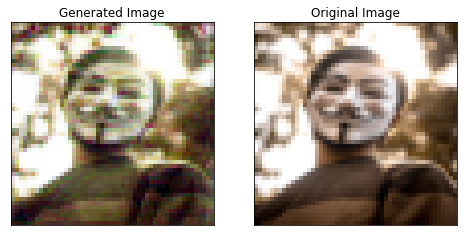

In [28]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title("Generated Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(out_g.detach().cpu().squeeze(0).numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
plt.show()